In [3]:
import sys
import os
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import glob

from st_utils import get_cell_by_gene
from st_utils import invert_y
from st_utils import df_2_gdf
from st_utils import get_gene_type
from st_utils import get_gdf_core
from st_utils import get_gdf_core_from_polygon
from st_utils import data_loader
from st_utils import transcript_loader

from constants import SCALING_FACTOR_DICT
from constants import CORE_RADIUS_DICT
from constants import POINTS_SRC_DICT
from constants import SAMPLES

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
wd = os.getcwd()
print (f'working directory: {wd}')

working directory: /mnt/disks/store/ist_benchmarking


In [2]:
# import os
# wd = os.getcwd()
# print (f'working directory: {wd}')

# sample = '2024_merscope_breast_htma'

# bucket = 'fc-b8e703d3-de2d-4532-94cc-efe864b4feea/SPARC/Revisions/202405032008_SPARCRevisionsHTMAJN3May24_VMSC11302'

# for i in range(3): # Number of regions
#     print (i)
#     folder = f'{wd}/data/{sample}/region_{i}'
#     if not os.path.exists(folder):
#         os.makedirs(folder)
    
#     cmd = f'gsutil cp gs://{bucket}/region_{i}/images/*csv {folder}'
#     cmd = f'gsutil cp gs://{bucket}/region_{i}/images/*z2* {folder}'
#     cmd = f'gsutil cp gs://{bucket}/region_{i}/*cell* {folder}'
#     cmd = f'gsutil cp gs://{bucket}/region_{i}/*detected_transcripts.csv* {folder}'
#     print (cmd)
#     ! {cmd}

# Tag cell-level data (Xenium, MERSCOPE, or CosMx)

sample: 2024_cosmx_multitissue_htma, panel: multitissue, tma:htma
144 cores
original: 265308, subset: 258986, pct: 97.62%


,orig.ident,transcript_counts,nFeature_RNA,nCount_negprobes,nFeature_negprobes,fov,Area,AspectRatio,x_FOV_px,y_FOV_px,Width,Height,Mean.PanCK,Max.PanCK,Mean.CD68,Max.CD68,Mean.Membrane,Max.Membrane,Mean.CD45,Max.CD45,Mean.DAPI,Max.DAPI,cell_id,assay_type,version,Run_Tissue_name,Panel,cellSegmentationSetId,cellSegmentationSetName,slide_ID_numeric,x,y,cell_ID,unassignedTranscripts,nCount_falsecode,nFeature_falsecode,Area.um2,propNegative,complexity,errorCtEstimate,percOfDataFromError,qcFlagsRNACounts,qcFlagsCellCounts,qcFlagsCellPropNeg,qcFlagsCellComplex,qcFlagsCellArea,qcCellsFlagged,median_negprobes,negprobes_quantile_0.9,median_RNA,RNA_quantile_0.9,nCell,nCount,nCountPerCell,nFeaturePerCell,propNegativeCellAvg,complexityCellAvg,errorCtPerCellEstimate,percOfDataFromErrorPerCell,qcFlagsFOV,i.median_negprobes,i.negprobes_quantile_0.9,i.median_RNA,i.RNA_quantile_0.9,x_centroid,y_centroid,core,tissue_type,geometry
cell_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
c_1_100_1,c,330.0,90.0,0.0,0.0,100,5551,0.89,581,44,80,90,5314,25995,203,2465,8017,35488,701,4398,4262,17811,c_1_100_1,RNA,v6,20240430_BWH_TMA_1,(1.0) (1.0) Human RNA Universal Cell Character...,fda50aa3-fc65-4043-8362-d2fc6d56ffe6,Initial Segmentation,1,5.861764,4.214475,c_1_100_1,0.174646,6.0,6.0,80.309124,0.000000,3.666667,0.0,0.000000,Pass,Pass,Pass,Pass,Pass,0,29.0,36.4,46.0,165.1,1132,164239.0,145.087456,56.877208,0.002672,2.044321,25.441696,0.175354,Pass,29.0,36.4,46.0,165.1,5.861764,4.214475,64,HNSCC,POINT (4.21448 5.86176)
c_1_100_10,c,233.0,91.0,1.0,1.0,100,8718,1.19,2066,48,117,98,3091,27135,339,2269,2229,24558,544,3052,7559,25474,c_1_100_10,RNA,v6,20240430_BWH_TMA_1,(1.0) (1.0) Human RNA Universal Cell Character...,fda50aa3-fc65-4043-8362-d2fc6d56ffe6,Initial Segmentation,1,5.861283,4.393092,c_1_100_10,0.174646,8.0,8.0,126.127715,0.004274,2.560440,100.0,0.429185,Pass,Pass,Pass,Pass,Pass,0,29.0,36.4,46.0,165.1,1132,164239.0,145.087456,56.877208,0.002672,2.044321,25.441696,0.175354,Pass,29.0,36.4,46.0,165.1,5.861283,4.393092,64,HNSCC,POINT (4.39309 5.86128)
c_1_100_100,c,691.0,163.0,1.0,1.0,100,8974,0.88,1278,645,115,130,2658,38496,233,4519,3325,23000,694,6180,7369,22601,c_1_100_100,RNA,v6,20240430_BWH_TMA_1,(1.0) (1.0) Human RNA Universal Cell Character...,fda50aa3-fc65-4043-8362-d2fc6d56ffe6,Initial Segmentation,1,5.789475,4.298311,c_1_100_100,0.174646,11.0,10.0,129.831396,0.001445,4.239264,100.0,0.144718,Pass,Pass,Pass,Pass,Pass,0,29.0,36.4,46.0,165.1,1132,164239.0,145.087456,56.877208,0.002672,2.044321,25.441696,0.175354,Pass,29.0,36.4,46.0,165.1,5.789475,4.298311,64,HNSCC,POINT (4.29831 5.78947)
c_1_100_1000,c,155.0,98.0,0.0,0.0,100,5396,0.71,2987,3245,79,112,533,1175,343,3037,897,4351,1025,3979,8201,17931,c_1_100_1000,RNA,v6,20240430_BWH_TMA_1,(1.0) (1.0) Human RNA Universal Cell Character...,fda50aa3-fc65-4043-8362-d2fc6d56ffe6,Initial Segmentation,1,5.476744,4.503871,c_1_100_1000,0.174646,3.0,3.0,78.066661,0.000000,1.581633,0.0,0.000000,Pass,Pass,Pass,Pass,Pass,0,29.0,36.4,46.0,165.1,1132,164239.0,145.087456,56.877208,0.002672,2.044321,25.441696,0.175354,Pass,29.0,36.4,46.0,165.1,5.476744,4.503871,64,HNSCC,POINT (4.50387 5.47674)
c_1_100_1001,c,13.0,12.0,0.0,0.0,100,3383,0.80,3286,3238,67,84,800,1554,304,591,843,1995,509,1387,8525,17003,c_1_100_1001,RNA,v6,20240430_BWH_TMA_1,(1.0) (1.0) Human RNA Universal Cell Character...,fda50aa3-fc65-4043-8362-d2fc6d56ffe6,Initial Segmentation,1,5.477586,4.539835,c_1_100_1001,0.174646,3.0,2.0,48.943572,0.000000,1.083333,0.0,0.000000,Pass,Fail,Pass,Pass,Pass,1,29.0,36.4,46.0,165.1,1132,164239.0,145.087456,56.877208,0.002672,2.044321,25.441696,0.175354,Pass,29.0,36.4,46.0,165.1,5.477586,4.539835,64,HNSCC,POINT (4.53984 5.47759)


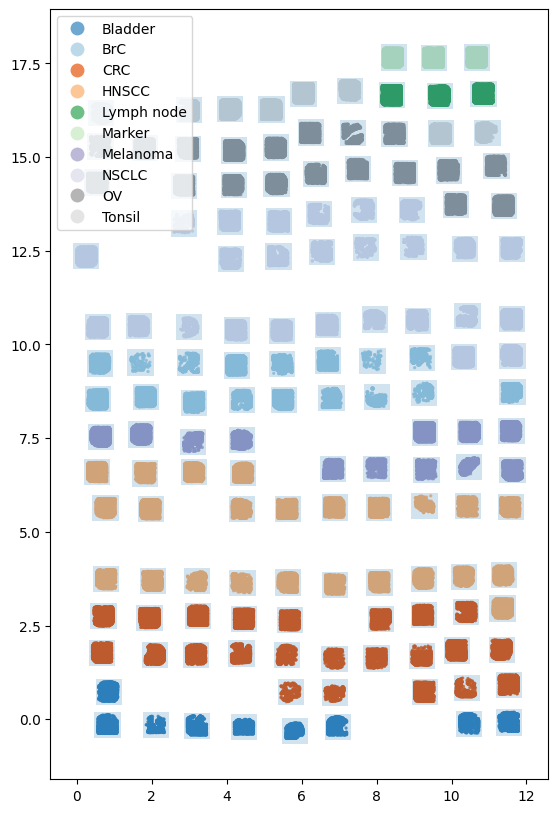

In [6]:
if not os.path.exists(f'{wd}/data/cell_level_csv'):
    os.makedirs(f'{wd}/data/cell_level_csv')

# for SAMPLE in SAMPLES[:6][1::2]: # using Xenium samples from the normal tissue TMA as example
for sample in SAMPLES[-2:-1]:
    panel = sample.split('_')[-2]
    tma = sample.split('_')[-1]
    print (f'sample: {sample}, panel: {panel}, tma:{tma}')

    # 1 pixel = scaling_factor um
    scaling_factor = SCALING_FACTOR_DICT[sample]
    radius_um = CORE_RADIUS_DICT[sample]

    # Metadata to be tagged
    additional_variables = ['core','tissue_type']
    subset_cols = ['core', 'tissue_type','x','y']

    ## Get core metadata

    # 1. Get core metadata including tissue_type, core ...
    csv_sample_info = f'{wd}/data/Sample_Info_{tma.upper()}_TMA - Sheet1.csv'

    # 2. Get core location (core centroid x/y in pixel or core polygon)
    csv_points = glob.glob(f'{wd}/data/{sample}/*points.csv')[0]  # Exported from a shapefile file manually generated using QGIS
    print (f'{len(pd.read_csv(csv_points))} cores')    

    if 'normal' in sample:
        # Get the gdf of core information with geometry (polygon)
        shapefile = f'{wd}/data/{sample}/{sample}_polygon.shp'
        gdf_core= get_gdf_core_from_polygon(shapefile, csv_sample_info, scaling_factor)
        if 'xenium' in sample:
            gdf_core['geometry'] = gdf_core['geometry'].apply(invert_y)  # modify y values to -y
    else:
        # Get the gdf of core information with geometry (buffer from the core centroid)
        gdf_core= get_gdf_core(csv_points, csv_sample_info, scaling_factor, radius_um, points_src=POINTS_SRC_DICT[sample])


    ##  Load raw cell-level data
    adata_full = data_loader(f'data/{sample}', sample.split('_')[-3])

    gdf_adata = adata_full.obs

    if '2024_cosmx' in sample:
        gdf_adata = df_2_gdf(gdf_adata, 'y', 'x')
    else:
        gdf_adata = df_2_gdf(gdf_adata, 'x', 'y')


    adata_gdf_sub = gdf_core[
        ['core','tissue_type','geometry']
        ].sjoin(gdf_adata, how='right', op='intersects'
                ).drop(columns='index_left').dropna(subset=['core'])

    print (f"original: {len(gdf_adata)}, subset: {len(adata_gdf_sub)}, pct: {round(100 * len(adata_gdf_sub)/len(gdf_adata), 2)}%")

    adata_gdf_sub = adata_gdf_sub.drop_duplicates(subset='cell_id')

    # Add metadata to adata.obs
    adata = adata_full[adata_full.obs['cell_id'].isin(adata_gdf_sub['cell_id']),:]
    for additional_variable in additional_variables:
        adata.obs[additional_variable] = adata.obs['cell_id'].map(adata_gdf_sub.set_index('cell_id')[additional_variable])

    # Convert dataframe to geodataframe
    if '2024_cosmx' in sample:
        gdf_c = df_2_gdf(adata.obs, 'y', 'x', crs="EPSG:4326", drop_xy=False)
    else:
        gdf_c = df_2_gdf(adata.obs, 'x', 'y', crs="EPSG:4326", drop_xy=False)

    display(gdf_c.head(5))

    gdf_c.to_parquet(f'{wd}/data/cell_level_csv/{sample}_cell_level.parquet.gzip', compression='gzip', index=False)
    adata.write_h5ad(f'{wd}/data/cell_level_csv/{sample}.h5ad')
    
    # Plot tagged cell-level data using geopandas
    fig, ax = plt.subplots(figsize=(20, 10))
    gdf_c.plot('tissue_type', ax=ax, aspect=1, markersize=2, legend=True, cmap='tab20c', alpha=0.7)
    gdf_core.plot(ax=ax, aspect=1, markersize=1,alpha=0.2)
    plt.show()



    # # You can also plot using squidpy if you prefer
    # sq.pl.spatial_scatter(
    # adata,
    # library_id="spatial",
    # color=[
    #     "tissue_type",
    #     'transcript_counts',
    # ],
    # shape=None,
    # size=2,
    # img=False,
    # )
    

# Tag transcript data (Xenium, MERSCOPE) using global x/y and spatial joining

sample: 2024_cosmx_multitissue_tumor2, panel: multitissue, tma:tumor2
47 cores
81250185


,core,tissue_type,,slideID,fov,x_FOV_px,y_FOV_px,CellId,txId,gene,cell_id,CellComp,codeclass,z_FOV_slice,x_slide_mm,y_slide_mm,z_slide_mm,modality,geometry
35247930,46,Melanoma,70998970,2,169,3396,4245,1533,172,IL1R1,c_2_169_1533,Cytoplasm,Endogenous,6,7.628436,4.510608,0.0048,cosmx,POINT (7.62844 4.51061)
30624553,46,Melanoma,61723678,2,169,3400,4245,1533,145,GPNMB,c_2_169_1533,Cytoplasm,Endogenous,6,7.628893,4.510612,0.0048,cosmx,POINT (7.62889 4.51061)
30624556,46,Melanoma,61723681,2,169,3400,4245,1533,149,GPNMB,c_2_169_1533,Cytoplasm,Endogenous,7,7.628887,4.510626,0.0056,cosmx,POINT (7.62889 4.51063)
35247933,46,Melanoma,70998973,2,169,3396,4245,1533,176,IL1R1,c_2_169_1533,Cytoplasm,Endogenous,7,7.628386,4.510643,0.0056,cosmx,POINT (7.62839 4.51064)
41882600,46,Melanoma,84397090,2,169,3388,4243,1533,222,PTGES3,c_2_169_1533,Cytoplasm,Endogenous,3,7.627467,4.510834,0.0024,cosmx,POINT (7.62747 4.51083)


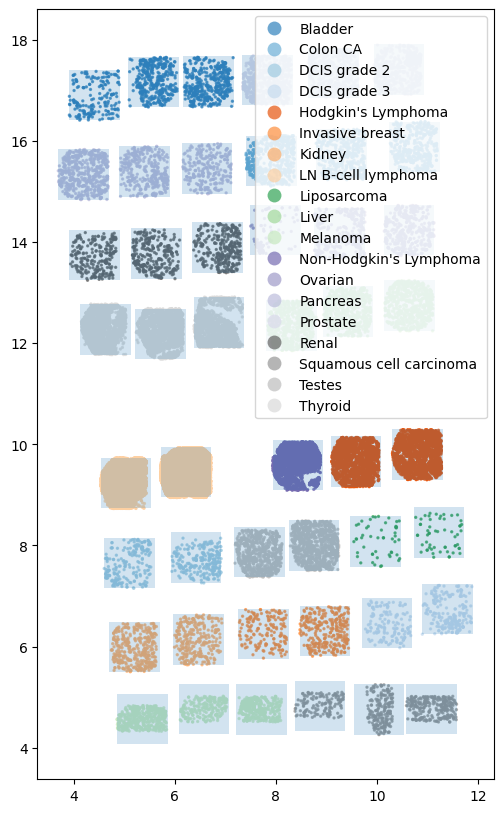

In [8]:
if not os.path.exists(f'{wd}/data/transcript_level_csv'):
    os.makedirs(f'{wd}/data/transcript_level_csv')

for sample in SAMPLES[-1:]:

    # try:
    panel = sample.split('_')[-2]
    tma = sample.split('_')[-1]
    print (f'sample: {sample}, panel: {panel}, tma:{tma}')

    # 1 pixel = scaling_factor um
    scaling_factor = SCALING_FACTOR_DICT[sample]
    radius_um = CORE_RADIUS_DICT[sample]

    # Metadata to be tagged
    additional_variables = ['core','tissue_type']
    subset_cols = ['core', 'tissue_type','x','y']

    ## Get core metadata

    # 1. Get core metadata including tissue_type, core ...
    csv_sample_info = f'{wd}/data/Sample_Info_{tma.upper()}_TMA - Sheet1.csv'

    # 2. Get core location (core centroid x/y in pixel or core polygon)
    csv_points = glob.glob(f'{wd}/data/{sample}/*points.csv')[0]  # Exported from a shapefile file manually generated using QGIS
    print (f'{len(pd.read_csv(csv_points))} cores')    

    if 'normal' in sample:
        # Get the gdf of core information with geometry (polygon)
        shapefile = f'{wd}/data/{sample}/{sample}_polygon.shp'
        gdf_core= get_gdf_core_from_polygon(shapefile, csv_sample_info, scaling_factor)
        if 'xenium' in sample:
            gdf_core['geometry'] = gdf_core['geometry'].apply(invert_y)  # modify y values to -y
    else:
        # Get the gdf of core information with geometry (buffer from the core centroid)
        gdf_core= get_gdf_core(csv_points, csv_sample_info, scaling_factor, radius_um, points_src=POINTS_SRC_DICT[sample])

    # Load raw transcript data
    df_t = transcript_loader(f'data/{sample}')
    
    if 'merscope' in sample:
        gdf_t = df_2_gdf(df_t, 'global_x', 'global_y', crs="EPSG:4326", drop_xy=False)
    elif '2024_cosmx' in sample:
        gdf_t = df_2_gdf(df_t, 'x_slide_mm', 'y_slide_mm', crs="EPSG:4326", drop_xy=False)
    else:
        gdf_t = df_2_gdf(df_t, 'global_y', 'global_x', crs="EPSG:4326", drop_xy=False) # Flip x and y


    # Pre-filter gdf_t using the spatial bounds of gdf_core to reduce size
    bounding_box = gdf_core.total_bounds
    potential_indices = list(gdf_t.sindex.intersection(bounding_box))
    filtered_gdf_t = gdf_t.iloc[potential_indices]

    # Perform spatial join on the filtered data
    gdf_join = gdf_core[['core', 'tissue_type', 'geometry']].sjoin(
        filtered_gdf_t, how='right', op='intersects'
    ).drop(columns='index_left').dropna(subset=['core'])
    
    # # gdf_join['core'] = gdf_join['core'].apply(lambda x: str(x).zfill(3))

    # Save data
    gdf_join.to_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip', compression='gzip', index=False)
    display(gdf_join.head(5))


    # Plot tagged cell-level data using geopandas
    fig, ax = plt.subplots(figsize=(20, 10))
    gdf_join.loc[gdf_join['gene']=='CD19'].plot('tissue_type', ax=ax, aspect=1, markersize=2, legend=True, cmap='tab20c', alpha=0.7)
    gdf_core.plot(ax=ax, aspect=1, markersize=1,alpha=0.2)
    plt.show()

    # except:
    #     print ('-----failed----')
    #     continue

# Tag transcript data (CosMx) with metadata using count table and cell id.
Risk: Transcript lost if it is not in a cell identified by segmentation.

In [3]:
if not os.path.exists(f'{wd}/data/transcript_level_csv'):
    os.makedirs(f'{wd}/data/transcript_level_csv')
    
for sample in SAMPLES[-1:]:
    print (sample)
    if '2024_cosmx' in sample:
        print ('2024 Cosmx data have global x/y, so the above code was used to tag the transcript instead of using cell_id')
    else:
        df_c = pd.read_parquet(f'{wd}/data/cell_level_csv/{sample}_cell_level.parquet.gzip')
        df_t = transcript_loader(f"data/{sample}")
        df_j = pd.merge(df_t, df_c[['core','tissue_type','cell_id']], on='cell_id', how='left')
        df_j = df_j.dropna()
        df_j = df_j.reset_index(drop=True)
        df_j.to_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip', compression='gzip', index=False)


2024_cosmx_multitissue_tumor2
81250185


# Get cell by gene data and tagged gene-level data

In [9]:
if not os.path.exists('data/cell_by_gene_csv'):
    os.makedirs('data/cell_by_gene_csv')

if not os.path.exists('data/gene_level_csv'):
    os.makedirs('data/gene_level_csv')

for sample in SAMPLES[-2:]:
    print (sample)
    df_t = pd.read_parquet(f'data/transcript_level_csv/{sample}_transcript_level.parquet.gzip', engine='pyarrow')

    # get cell by gene data
    df_cell_by_gene = get_cell_by_gene(df_t, sample)
    df_cell_by_gene.to_parquet((f'data/cell_by_gene_csv/{sample}_cell_by_gene.parquet.gzip'))

    # get tagged gene level data grouped by core/gene/tissue_type
    gr_by = ['core','gene','tissue_type']
    df_metric = df_t.groupby(by = gr_by, as_index=False).count()[gr_by+['cell_id']]
    df_metric = df_metric.rename(columns = {'cell_id':'count'})
    df_metric['code_type'] = df_metric['gene'].apply(lambda x: get_gene_type(x))
    df_metric.to_csv(f'data/gene_level_csv/gene_level_csv_{sample}.csv', index=False)



2024_cosmx_multitissue_htma
2024_cosmx_multitissue_tumor2
